In [49]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [50]:
bikes_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/bikes_sharing.csv')
bikes_df.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


In [51]:
bikes_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [52]:
# Feature Engineering

# Daily version of dataset
# Datetime column into a datetime function

bikes_df['datetime'] = pd.to_datetime(bikes_df['datetime'])
bikes_df.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [53]:
bikes_daily = bikes_df.set_index('datetime')

In [54]:
bikes_daily = bikes_daily.resample('D').aggregate({'season':'max', 'holiday':'max','workingday':'max', 'weather':'max',
                                                   'temp':'mean', 'atemp':'mean', 'humidity':'mean', 'windspeed':'mean',
                                                    'casual':'sum', 'registered':'sum', 'count':'sum'})
# bikes_daily = bikes_daily.resample('D').aggregate({'season':'max', 'holiday':'max','workingday':'max', 'weather':'max',\
#                                                   'temp':'mean', 'atemp':'mean', 'humidity':'mean', 'windspeed':'mean',\
#                                                    'casual':'sum', 'registered':'sum', 'count':'sum'})

In [55]:
bikes_daily

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01,1.0,0.0,0.0,3.0,14.110833,18.181250,80.583333,10.749871,331,654,985
2011-01-02,1.0,0.0,0.0,3.0,14.902609,17.686957,69.608696,16.652122,131,670,801
2011-01-03,1.0,0.0,1.0,1.0,8.050909,9.470227,43.727273,16.636709,120,1229,1349
2011-01-04,1.0,0.0,1.0,2.0,8.200000,10.606087,59.043478,10.739809,108,1454,1562
2011-01-05,1.0,0.0,1.0,1.0,9.305217,11.463478,43.695652,12.522300,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-15,4.0,0.0,0.0,2.0,13.290833,16.919167,65.041667,7.125450,767,4280,5047
2012-12-16,4.0,0.0,0.0,3.0,14.862500,18.496875,83.875000,6.749692,538,3248,3786
2012-12-17,4.0,0.0,1.0,3.0,16.126667,20.075000,90.708333,6.583308,212,4373,4585


In [56]:
bikes_df.iloc[:24].sum()

season          24.0000
holiday          0.0000
workingday       0.0000
weather         38.0000
temp           338.6600
atemp          436.3500
humidity      1934.0000
windspeed      257.9969
casual         331.0000
registered     654.0000
count          985.0000
dtype: float64

In [57]:
# Isolate the hour of the day to assess time of the day

bikes_df['hour'] = bikes_df['datetime'].apply(lambda x: x.hour)
bikes_df.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,4
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,5
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,6
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,7
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14,9


In [58]:
def time_of_day(x):
    if x>= 6 and x<= 9:
        return 'morning_commute'
    elif x > 9 and x <= 15:
        return 'midday'
    elif x > 3 and x <= 19:
        return 'evening_commute'
    else:
        return 'afterhours'

bikes_df['time_of_day'] = bikes_df['hour'].apply(time_of_day)
bikes_df.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,time_of_day
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0,afterhours
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,afterhours
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2,afterhours
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,3,afterhours
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,4,evening_commute
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,5,evening_commute
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,6,morning_commute
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,7,morning_commute
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8,8,morning_commute
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14,9,morning_commute


In [59]:
bikes_df['weekday'] = bikes_df['datetime'].apply(lambda x: x.weekday())
bikes_df.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,time_of_day,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0,afterhours,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,afterhours,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2,afterhours,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,3,afterhours,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,4,evening_commute,5
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,5,evening_commute,5
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,6,morning_commute,5
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,7,morning_commute,5
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8,8,morning_commute,5
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14,9,morning_commute,5


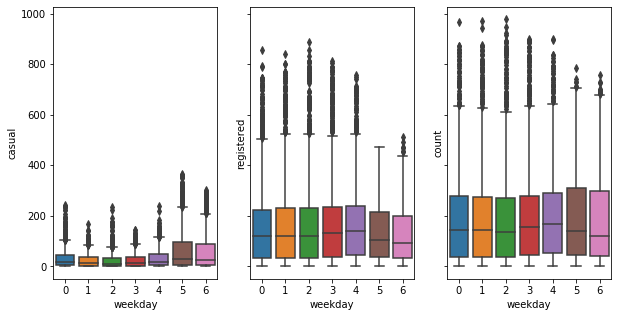

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate weekday vs number of casual or registered or total rentals

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5), sharey = True)
sns.boxplot(x = 'weekday', y = 'casual', data = bikes_df, ax = ax1, palette = 'tab10')
sns.boxplot(x = 'weekday', y = 'registered', data = bikes_df, ax = ax2, palette = 'tab10')
sns.boxplot(x = 'weekday', y = 'count', data = bikes_df, ax = ax3, palette = 'tab10')

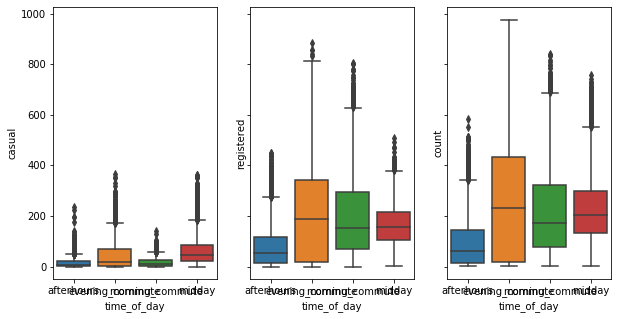

In [61]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5), sharey = True)
sns.boxplot(x = 'time_of_day', y = 'casual', data = bikes_df, ax = ax1, palette = 'tab10')
sns.boxplot(x = 'time_of_day', y = 'registered', data = bikes_df, ax = ax2, palette = 'tab10')
sns.boxplot(x = 'time_of_day', y = 'count', data = bikes_df, ax = ax3, palette = 'tab10')

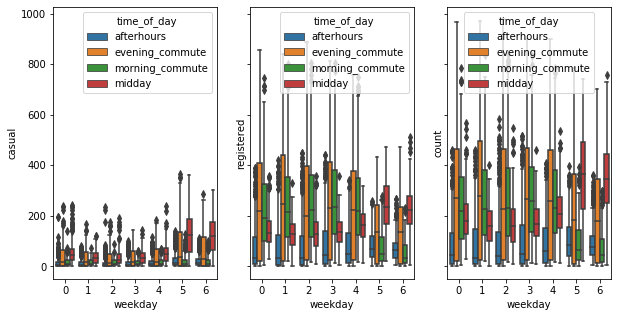

In [62]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5), sharey = True)
sns.boxplot(x = 'weekday', y = 'casual', hue = 'time_of_day',data = bikes_df, ax = ax1, palette = 'tab10')
sns.boxplot(x = 'weekday', y = 'registered', hue = 'time_of_day', data = bikes_df, ax = ax2, palette = 'tab10')
sns.boxplot(x = 'weekday', y = 'count', hue = 'time_of_day', data = bikes_df, ax = ax3, palette = 'tab10')

c:\Users\LENOVO\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  after removing the cwd from sys.path.
c:\Users\LENOVO\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  """
c:\Users\LENOVO\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  


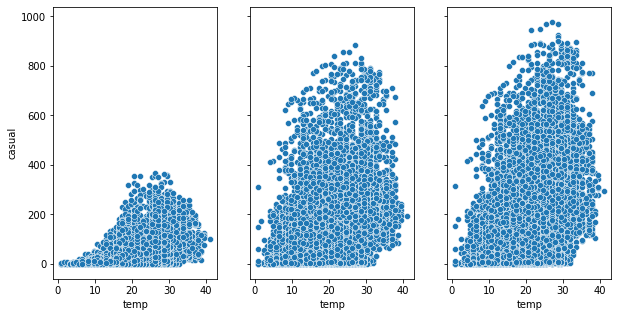

In [63]:
# Evaluationg temperature vs Rental Counts

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5), sharey = True)
sns.scatterplot(x = 'temp', y = 'casual', data = bikes_df, ax = ax1, palette = 'tab10')
sns.scatterplot(x = 'temp', y = 'registered', data = bikes_df, ax = ax2, palette = 'tab10')
sns.scatterplot(x = 'temp', y = 'count', data = bikes_df, ax = ax3, palette = 'tab10')

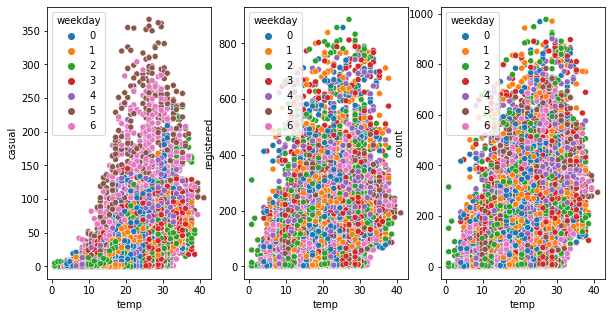

In [64]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5), sharey = False)
sns.scatterplot(x = 'temp', y = 'casual', hue = 'weekday', data = bikes_df, ax = ax1, palette = 'tab10')
sns.scatterplot(x = 'temp', y = 'registered', hue = 'weekday', data = bikes_df, ax = ax2, palette = 'tab10')
sns.scatterplot(x = 'temp', y = 'count', hue = 'weekday', data = bikes_df, ax = ax3, palette = 'tab10')

In [65]:
# 3 variables: Temp, weekday and time_of_day
# For categories, they need to be converted into dummy variables (get_dummies())
# The day needs to be one-hot encoded 

model_data = pd.get_dummies(data = bikes_df[['casual','temp', 'weekday', 'time_of_day']], columns = ['weekday', 'time_of_day'])
model_data.head()

,casual,temp,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,time_of_day_afterhours,time_of_day_evening_commute,time_of_day_midday,time_of_day_morning_commute
0,3,9.84,0,0,0,0,0,1,0,1,0,0,0
1,8,9.02,0,0,0,0,0,1,0,1,0,0,0
2,5,9.02,0,0,0,0,0,1,0,1,0,0,0
3,3,9.84,0,0,0,0,0,1,0,1,0,0,0
4,0,9.84,0,0,0,0,0,1,0,0,1,0,0


In [66]:
# Ordinary least squares regression
# Linear Regression model
model_data.columns

model = ols("casual ~ temp + weekday_1 + weekday_2 + weekday_3 +\
       weekday_4 + weekday_5 + weekday_6 +\
       time_of_day_evening_commute + time_of_day_midday + time_of_day_morning_commute", data = model_data).fit()

In [67]:
# R-squared describes the variability of the model
# Statitical model so it is not deterministic i.e. the line of best fit won't be very accurate
# Adding additional vaiables will increase the R-Squared value
# If adjusted R-Squared value is lesser than actual R-Squared value the added variable is not useful
# Coef are read as for every increase in value in that column it will increase/decrease based on the value specified
# P>|t| >> P-value is determined using t-tests


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 casual   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     900.6
Date:                Wed, 26 Jun 2024   Prob (F-statistic):               0.00
Time:                        21:07:36   Log-Likelihood:                -54740.
No. Observations:               10886   AIC:                         1.095e+05
Df Residuals:                   10875   BIC:                         1.096e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [80]:
predictions  = model.predict(model_data.iloc[:,1:])

In [70]:
model.params

Intercept                     -43.237276
temp                            2.689481
weekday_1                      -7.189427
weekday_2                      -6.492077
weekday_3                      -4.806992
weekday_4                       2.930185
weekday_5                      36.427394
weekday_6                      28.839987
time_of_day_evening_commute    24.184310
time_of_day_midday             43.474930
time_of_day_morning_commute     3.730344
dtype: float64

In [73]:
predictions

0        19.654607
1        17.449233
2        17.449233
3        19.654607
4        43.838916
           ...    
10881    16.357065
10882   -10.032619
10883   -12.237993
10884   -12.237993
10885   -14.443367
Length: 10886, dtype: float64

In [78]:
final_data = pd.concat([model_data, predictions], axis =1)

In [82]:
final_data.rename(columns = (0: 'predictions'), inplace = True)

SyntaxError: invalid syntax (<ipython-input-82-f0183df339d3>, line 1)

In [68]:
new_model = ols("casual ~ temp + weekday_0 + weekday_1 + weekday_2 +\
       weekday_3 + weekday_5 + weekday_6 +\
       time_of_day_evening_commute + time_of_day_afterhours + time_of_day_morning_commute", data = model_data).fit()

In [69]:
print(new_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 casual   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     900.6
Date:                Wed, 26 Jun 2024   Prob (F-statistic):               0.00
Time:                        21:24:11   Log-Likelihood:                -54740.
No. Observations:               10886   AIC:                         1.095e+05
Df Residuals:                   10875   BIC:                         1.096e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [76]:
new_predictions  = new_model.predict(model_data.iloc[:,1:])

In [77]:
new_predictions

0        19.654607
1        17.449233
2        17.449233
3        19.654607
4        43.838916
           ...    
10881    16.357065
10882   -10.032619
10883   -12.237993
10884   -12.237993
10885   -14.443367
Length: 10886, dtype: float64

In [ ]:
import statsmodels.api as sm

sm.graphics.influence_plot(model, criterion = 'cooks')

In [ ]:
np.mean(np.sqrt(final_data['residuals']**2))
np.mean(final_data.casual)

# Closer to 0 the better the model as it will have less variance as compared to actual values
prediction_error_ratio = np.mean(final_data.casual) / np.mean(np.sqrt(final_data['residuals']**2))